In [11]:
import urllib.request
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
from datetime import date
import re

In [12]:
url = 'https://api.vk.com/method/'
owner_id = '-25557243'
posts_count = '100'

token = '8423c2448423c2448423c244d08441f2a1884238423c244dee' \
        '1644d9e90529494134bf8'

In [13]:
def getPosts(count=0):
    new_posts_json = []
    offset = 1
    date = '2019'
    while date != '2017':

        reqURL = url + 'wall.get?owner_id=' + owner_id + '&offset=' + str(
            offset) + '&count=100&v=5.95&access_token=' + token
        offset += 100

        req = urllib.request.Request(reqURL)
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        for post_info in data['response']['items']:
            unixtime = post_info['date']
            utc = datetime.fromtimestamp(unixtime).strftime("%m.%Y")
            print(utc)
            if utc.split('.')[1] == '2017':
                date = '2017'
                print('out of year, current post date = ' + utc)
                break
            if post_info['text'] == '':
                try:
                    if post_info['copy_history'][0]['text'] != '':
                        new_posts_json.append({
                            'id': post_info['id'],
                            'date': utc,
                            'text': post_info['copy_history'][0]['text']
                        })
                except KeyError:
                    print('empty post')
                    pass
            else:
                new_posts_json.append({
                    'id': post_info['id'],
                    'date': utc,
                    'text': post_info['text']
                })

    return new_posts_json

In [14]:
def getComments(posts):
    posts_with_comments = []
    comments_for_sort = []
    i = 0
    for post_info in posts:
        print(str(len(posts) - i) + ' left')
        print(post_info['date'])
        if post_info['date'] == '12.2018':
            break
        offset = 0
        comments_for_post = []
        # print(type(post_info))
        # print(post_info)
        posts_with_comments.append({
                    'id': post_info['id'],
                    'date': post_info['date'],
                    'text': post_info['text'],
                })
        while True:
            reqURL = url + 'wall.getComments?owner_id=' + owner_id + '&post_id=' + str(post_info['id']) + '&offset=' + \
                     str(offset) + '&count=100&v=5.95&access_token=' + token + '&extended=1&fields=city,sex'
            offset += 100

            req = urllib.request.Request(reqURL)
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data = json.loads(result)
            comments_for_sort = []
            if data['response']['items'] != []:
                for comment in data['response']['items']:
                    try:
                        comments_for_sort.append({
                            'id': comment['from_id'],
                            'text': comment['text']
                        })
                    except KeyError:
                        continue
                comments_for_sort = sorted(comments_for_sort, key=lambda k: k['id'])
                com_index = 0
                for comment_sorted in comments_for_sort:
                    # print(reqURL)
                    # print(len(data['response']['profiles']))
                    # print(len(comments_for_sort))
                    try:
                        if comment_sorted['id'] == data['response']['profiles'][com_index]['id']:
                            try:
                                comment_sorted['sex'] = data['response']['profiles'][com_index]['sex']
                            except KeyError:
                                comment_sorted['sex'] = 0
                            try:
                                comment_sorted['city'] = data['response']['profiles'][com_index]['city']['title']
                            except KeyError:
                                comment_sorted['city'] = 'unknown'
                            com_index += 1
                    except IndexError:
                        break
                comments_for_post.append(comments_for_sort)
            else:
                break
        posts_with_comments[i]['comments'] = comments_for_post
        i += 1
    return posts_with_comments

In [ ]:
posts = getPosts()
with open('WallBadComedian.txt', 'w', encoding="utf-8") as file:
    file.write(json.dumps(posts, indent=4, sort_keys=True))



with open('WallBadComedian.txt', 'r', encoding="utf-8") as file:
    posts = file.read()
posts = json.loads(posts)
comms = getComments(posts)
with open('CommentsBadComedian.txt', 'w', encoding="utf-8") as file:
    file.write(json.dumps(comms, indent=4, sort_keys=True))

In [16]:
with open('CommentsBadComedian.txt', 'r', encoding="utf-8") as file:
    comments_and_posts = file.read()
    comments_and_posts = json.loads(comments_and_posts)

post_length = []
avg_comment_len = []
post_date = {}
mens_comments = {'count': 0,
                 'length': 0}
womans_comments = {'count': 0,
                   'length': 0}

cities = {}

In [ ]:
with open('CorpusBadComedian.txt', 'w', encoding="utf-8") as file:
    for post_info in comments_and_posts:
        file.write(post_info['text'] + '\n\n')
        try:
            list = post_info['comments'][0]
        except IndexError:
            continue
        for com in list:
            file.write(com['text'] + '\n')
        file.write('\n\n\n\n')

In [17]:
for post_info in comments_and_posts:
    length = len(post_info['text'].split(' '))
    post_length.append(length)
    avg = 0
    i = 1
    try:
        post_date[post_info['date']] += length
    except KeyError:
        post_date[post_info['date']] = length
    try:
        list = post_info['comments'][0]
    except IndexError:
        continue
    for comments in list:
        len_com = len(comments['text'].split(' '))
        try:
            cities[comments['city']]['length'] += len_com
            cities[comments['city']]['count'] += 1
        except KeyError:
            try:
                cities[comments['city']] = {}
                cities[comments['city']]['length'] = len_com
                cities[comments['city']]['count'] = 1
            except KeyError:
                pass

        try:
            if comments['sex'] == 1:
                womans_comments['count'] += 1
                womans_comments['length'] += len_com
            if comments['sex'] == 2:
                mens_comments['count'] += 1
                mens_comments['length'] += len_com
        except KeyError:
            pass
        avg += len_com
        i += 1
    avg_comment_len.append(avg / i)

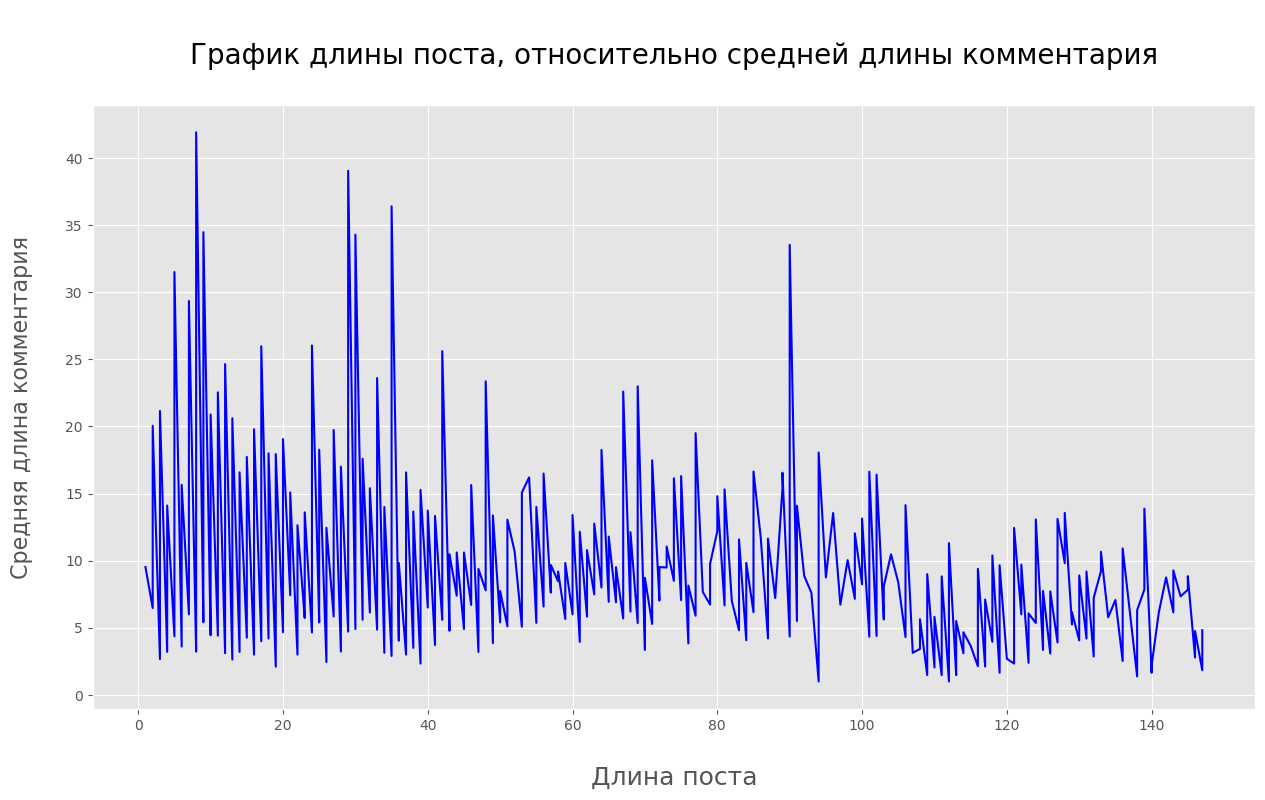

In [18]:
style.use('ggplot')
plt.figure(figsize=(15, 8), dpi=100)
list1, list2 = zip(*sorted(zip(post_length, avg_comment_len)))
plt.plot(list1[:1050], list2[:1050], 'b')
plt.title('\nГрафик длины поста, относительно средней '
          'длины комментария\n', fontsize=20)
plt.ylabel('Средняя длина комментария\n', fontsize=16)
plt.xlabel('\nДлина поста', fontsize=18)
plt.show()

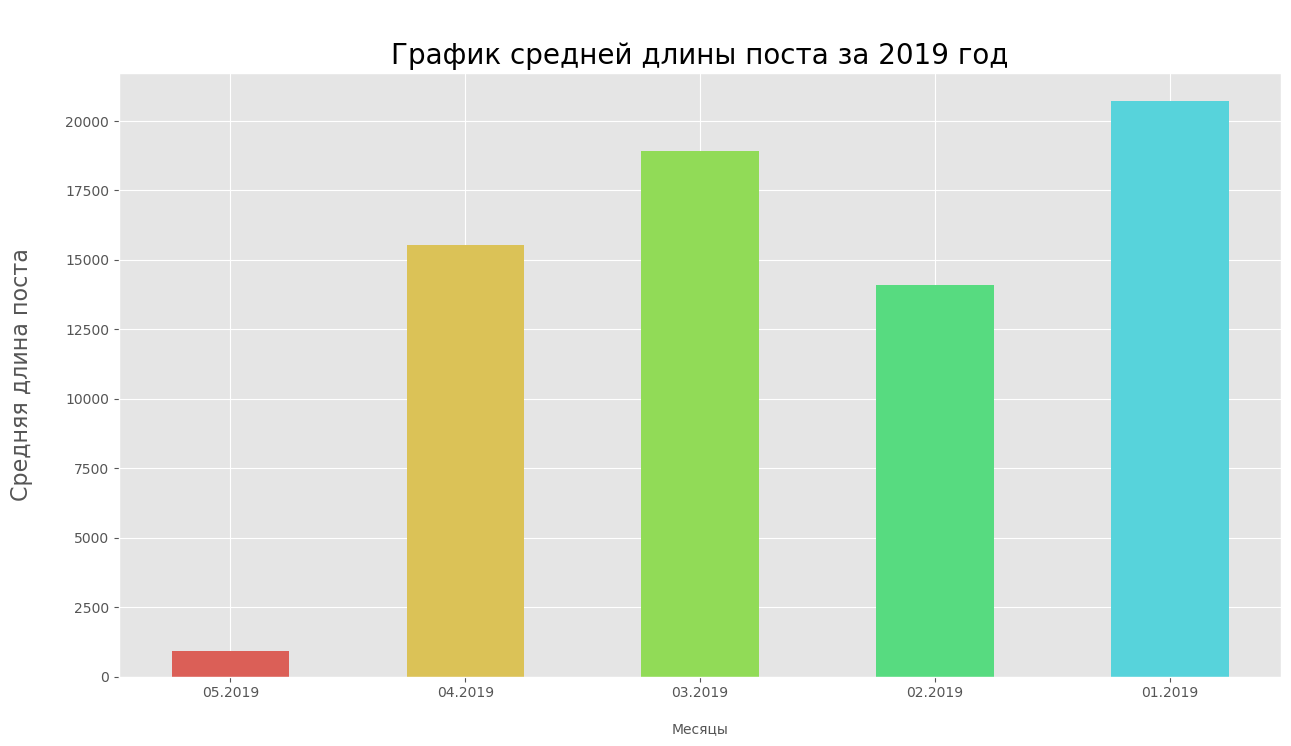

In [19]:
plt.figure(figsize=(15, 8), dpi=100)
colors = sns.color_palette("hls", 8)
plt.bar(post_date.keys(), post_date.values(), color=colors, width=0.5)
plt.title('\nГрафик средней длины поста за 2019 год', fontsize=20)
plt.ylabel('Средняя длина поста\n', fontsize=16)
plt.xlabel('\nМесяцы', fontsize=10)
plt.show()

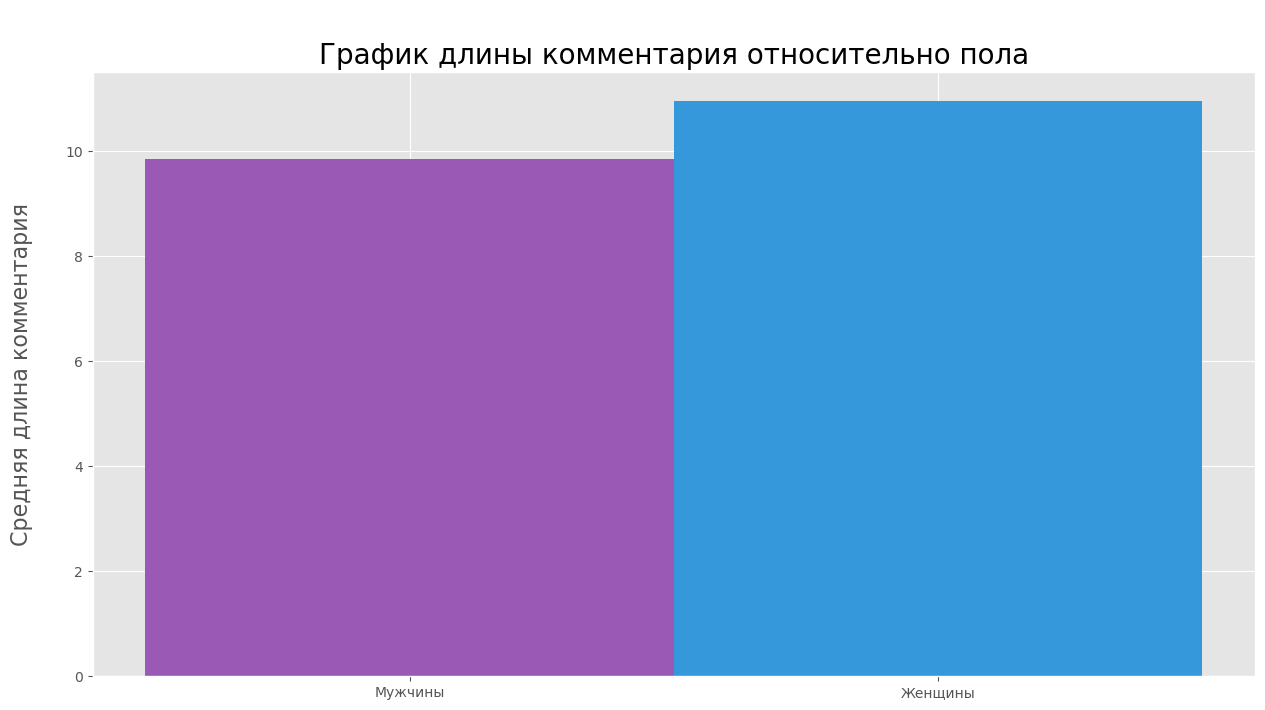

In [20]:
plt.figure(figsize=(15, 8), dpi=100)
colors = sns.color_palette(["#9b59b6", "#3498db"])
plt.bar(['Мужчины','Женщины'], [mens_comments['length']/mens_comments['count'], womans_comments['length']/womans_comments['count']], color=colors, width=1)
plt.title('\nГрафик длины комментария относительно пола', fontsize=20)
plt.ylabel('Средняя длина комментария\n', fontsize=16)
plt.show()

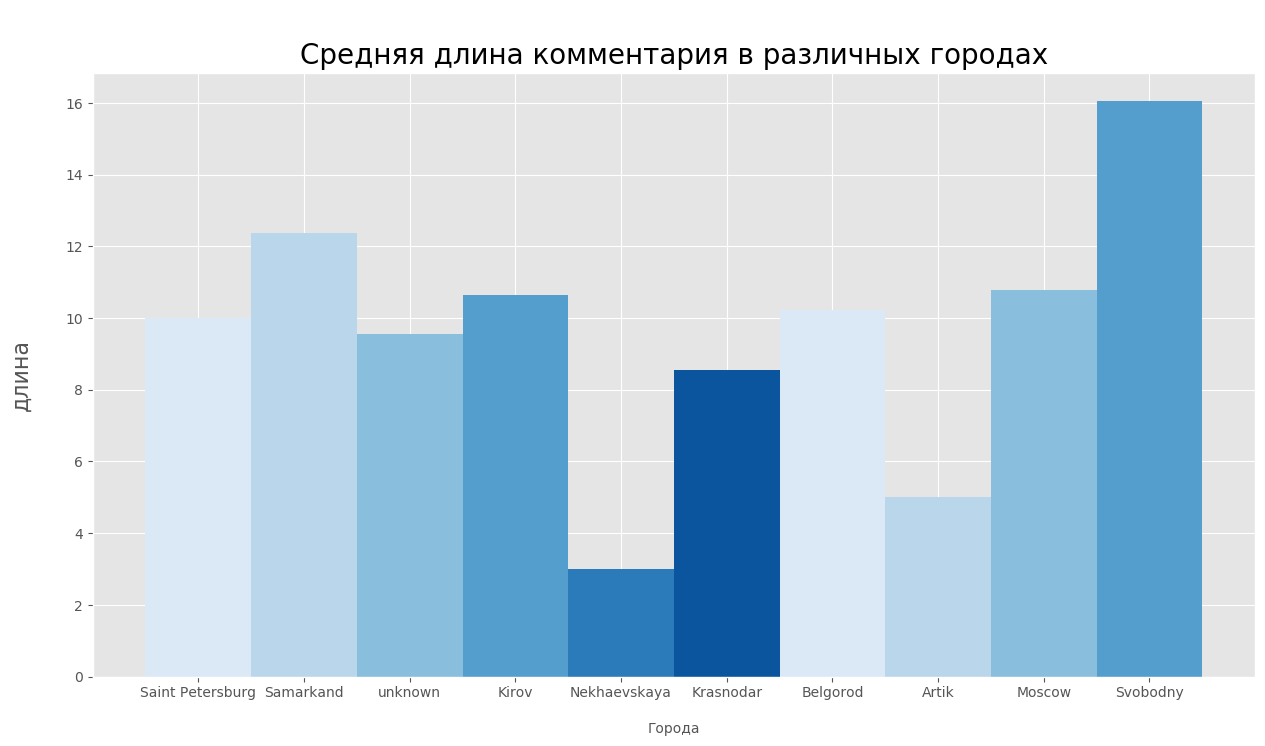

In [21]:
    cities_name = []
    cities_avg = []
    for key, value in cities.items():
        cities_name.append(key)
        cities_avg.append(value['length'] / value['count'])

    plt.figure(figsize=(15, 8), dpi=100)
    colors = sns.color_palette("Blues")
    plt.bar(cities_name[:10], cities_avg[:10],
            color=colors, width=1)
    plt.title('\nСредняя длина комментария в различных городах', fontsize=20)
    plt.ylabel('длина\n', fontsize=16)
    plt.xlabel('\nГорода', fontsize=10)
    plt.show()